In [26]:
import comat

import pandas as pd

badd = pd.read_csv("./scge_code_data_24_03/data/bank-additional/bank-additional-full.csv",sep=";")

In [27]:
target = badd.y

In [28]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(badd,target,test_size=0.2, random_state=1500)


In [30]:


def bank_data_prep(bank_data):
    '''
    input: data frame. here the data propressing is customized for bank data
    '''
    
    #check the NA values in bankdata
    #print('check the NAs in bank_data', bank_data.isnull().sum())
        
    #remove useless columns
    re_cols=['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']
    bank_data.drop(re_cols,axis=1,inplace=True)
    # set up visualization 
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    #change letters to strings
    bank_data = bank_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    #replace "?" by na
    bank_data.replace('?',np.nan,inplace=True)
    
    #remove NAs
    bank_data.dropna(inplace=True)
    
    # Get all categorical features
    cat_columns = list(bank_data.columns[bank_data.dtypes=='object'])   
    
    cat_columns.remove('y')
    #dummy target variable
    bank_data['y'] = (bank_data['y']=='yes').apply(int) 
    return(bank_data,cat_columns)

In [31]:
X_train, cat_cols = bank_data_prep(X_train)
X_test, cat_cols = bank_data_prep(X_test)

In [34]:
y_train = X_train.y
y_test = X_test.y

In [5]:
import numpy as np
X_train.dtypes

col_names = ["job", "marital", "education","default","housing","loan","contact","month","day_of_week","poutcome"]


X_train=X_train.replace('?',np.nan)

#remove na

X_train.dropna(inplace=True)

In [35]:
co_ma = comat.create_cooccurrence_matrix_diag(col_names,X_train[col_names])

[[0.1        0.00621762 0.01960477 ... 0.01967707 0.01959272 0.06993614]
 [0.02471264 0.1        0.         ... 0.02260536 0.01135057 0.07476054]
 [0.03282889 0.         0.1        ... 0.02838983 0.02046005 0.07066182]
 ...
 [0.01667143 0.00481869 0.01436418 ... 0.10391825 0.01950956 0.05776299]
 [0.025      0.00364391 0.01559041 ... 0.02938192 0.1        0.0676968 ]
 [0.02669782 0.00718044 0.01610885 ... 0.02602624 0.02025336 0.10275718]]
                       admin.       apr       aug  basic.4y  basic.6y   
admin.               0.100000  0.006218  0.019605  0.000735  0.001350  \
apr                  0.024713  0.100000  0.000000  0.010297  0.004789   
aug                  0.032829  0.000000  0.100000  0.008454  0.002179   
basic.4y             0.001812  0.006386  0.012444  0.100000  0.000000   
basic.6y             0.006150  0.005491  0.005931  0.000000  0.100000   
basic.9y             0.008385  0.006180  0.006201  0.000000  0.000000   
blue-collar          0.000000  0.006037  0.00

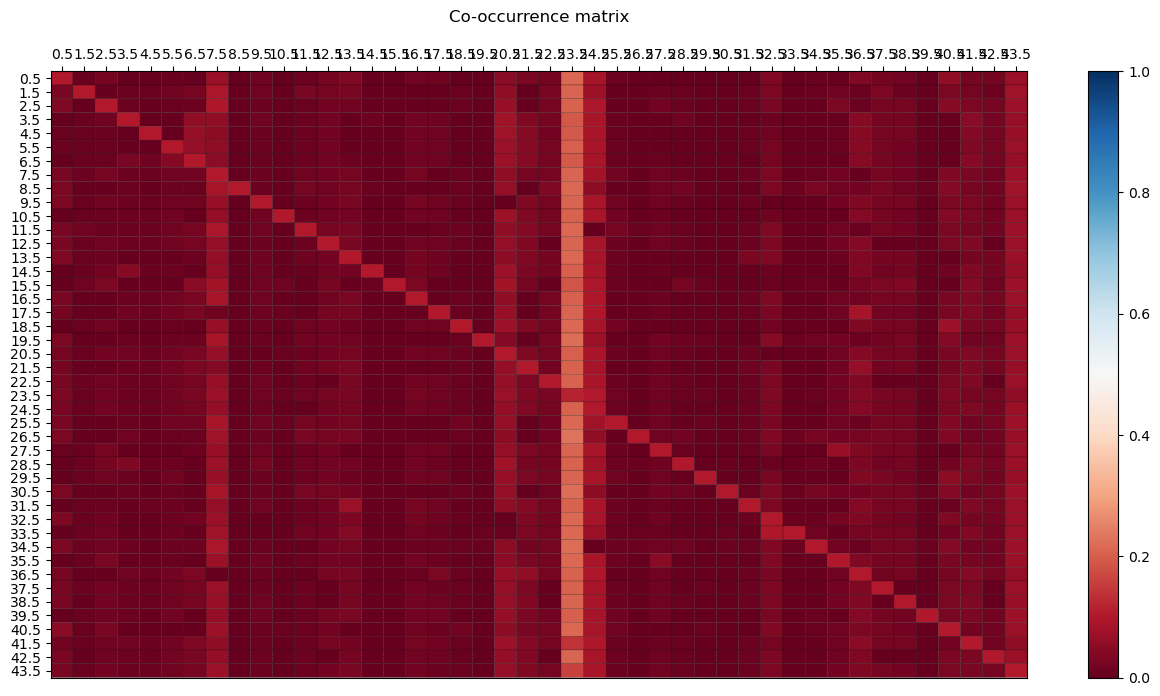

In [36]:
df_co_occ_values = co_ma.values 
 # Plotting
x_axis_size = df_co_occ_values.shape[0]
y_axis_size = df_co_occ_values.shape[1]
title = "Co-occurrence matrix\n"
xlabel= ''#"Labels"
ylabel= ''#"Labels"
#xticklabels = label_header_with_count
#yticklabels = label_header_with_count


comat.heatmap(df_co_occ_values, title, xlabel, ylabel, None, None)

In [37]:
A = co_ma.values


In [9]:
co_ma.columns

Index(['admin.', 'apr', 'aug', 'basic.4y', 'basic.6y', 'basic.9y',
       'blue-collar', 'cellular', 'dec', 'divorced', 'entrepreneur', 'failure',
       'fri', 'high.school', 'housemaid', 'illiterate', 'jul', 'jun',
       'management', 'mar', 'married', 'may', 'mon', 'no', 'nonexistent',
       'nov', 'oct', 'professional.course', 'retired', 'self-employed', 'sep',
       'services', 'single', 'student', 'success', 'technician', 'telephone',
       'thu', 'tue', 'unemployed', 'university.degree', 'unknown', 'wed',
       'yes'],
      dtype='object')

In [38]:
from sklearn.preprocessing import OneHotEncoder


oht = OneHotEncoder()

oht.fit(np.array([co_ma.columns]).T)

oht

OneHotEncoder()

In [39]:
x = oht.transform(np.array([co_ma.columns]).T).toarray()

Adj_t = A

#Adj = A

Adj = A

In [12]:
print(np.shape(x))
np.shape(Adj_t)

(44, 44)


(44, 44)

In [40]:
dimpool = 30
model =comat.DiffPool(44,dimpool,44)

In [41]:

import torch
import torch.nn.functional as F

x_t = torch.as_tensor(x).float()
A_t = torch.as_tensor(Adj).float()
T_t = torch.as_tensor(Adj_t).float()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



def train(epoch):
    model.train()
    loss_all = 0
    for i in range(epoch):
        optimizer.zero_grad()
        output,s1,o1,s2,o2,linkl = model(x_t, A_t)
        #output,s1,o1,linkl = model(x_t, A_t)
        #print(output)
        #print(A_t)
        loss = F.mse_loss(output, T_t)+ 0.1*linkl 
        loss.backward()
        #print(loss)
        loss_all += float(loss)
        optimizer.step()
    return loss_all / epoch


train(1000)

0.008562080143557978

In [42]:
output, s1, A1,s2,A2,LL = model(x_t, A_t)

In [43]:
pf= X_train
columns_categorical = col_names

In [44]:
from tqdm import tqdm_notebook as tqdm

elements = []


for row in tqdm(pf.iterrows()):
    categorical_embeddings = []
    for i in columns_categorical:
        #print(i,row[1][i])
        try:
            categorical_embeddings.append(s1[0,np.argmax(oht.transform([np.array([row[1][i]])]).todense()),:].detach().numpy())
        except:
            categorical_embeddings.append(np.zeros((dimpool)))
    elements.append(np.array(categorical_embeddings))

/tmp/ipykernel_184819/3874920952.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(pf.iterrows()):


0it [00:00, ?it/s]

In [45]:
elements

reshaped_x = (np.reshape(elements,(32950,len(columns_categorical)*dimpool)))

In [47]:
pf.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
29504,46,blue-collar,married,basic.9y,unknown,yes,no,cellular,apr,mon,188,1,999,0,nonexistent,0
18699,36,technician,single,professional.course,no,no,no,telephone,jul,thu,237,7,999,0,nonexistent,0
33694,28,technician,married,basic.9y,no,yes,no,cellular,may,wed,23,1,999,1,failure,0
8238,44,admin.,single,university.degree,no,no,yes,telephone,jun,tue,143,1,999,0,nonexistent,0
4941,32,admin.,single,university.degree,no,yes,no,telephone,may,wed,175,2,999,0,nonexistent,0


In [48]:
np.where(pf.dtypes!="object")[0]

array([ 0, 10, 11, 12, 13, 15])

In [49]:
pf = pf.iloc[:, [0, 10, 11, 12, 13, 15]].reset_index()
del pf["index"]

In [52]:
del pf["y"]

In [53]:
pf.head()

,age,duration,campaign,pdays,previous
0,46,188,1,999,0
1,36,237,7,999,0
2,28,23,1,999,1
3,44,143,1,999,0
4,32,175,2,999,0


In [54]:
reshaped_x


my_data = pd.concat([pf,pd.DataFrame(reshaped_x)],axis=1)


np.shape(my_data)

(32950, 305)

In [55]:
my_data['target'] = y_train.values


my_data.to_csv('bank_diffpool_paired_ttest.csv')

In [48]:
from sklearn.model_selection import train_test_split


X_train2, X_test2, y_train2, y_test2 = train_test_split(my_data,y_train,test_size=0.2, random_state=1500)


In [49]:
X_train2

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,290,291,292,293,294,295,296,297,298,299
15234,45,290,1,999,0,1.4,94.465,-41.8,4.961,5228.1,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
4546,26,1087,1,3,1,-1.7,94.027,-38.3,0.904,4991.6,...,0.000000,0.000000,0.000000,0.0,0.0,0.92638,0.0,0.0,1.426544,3.024623
5595,36,610,2,999,0,1.4,93.444,-36.1,4.965,5228.1,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
28008,49,119,1,6,1,-1.8,93.749,-34.6,0.642,5008.7,...,0.000000,0.000000,0.000000,0.0,0.0,0.92638,0.0,0.0,1.426544,3.024623
24022,42,24,12,999,0,1.4,93.918,-42.7,4.962,5228.1,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27783,42,146,4,999,0,-2.9,92.201,-31.4,0.834,5076.2,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
19091,32,106,1,999,0,1.4,93.444,-36.1,4.964,5228.1,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
16834,46,351,3,999,0,-1.8,93.876,-40.0,0.692,5008.7,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
24769,35,137,1,999,0,1.4,93.444,-36.1,4.965,5228.1,...,1.055838,0.536874,0.347205,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,auc, roc_auc_score


log = LogisticRegression(max_iter=1000)


stc = StandardScaler()

X_scaled = stc.fit_transform(X_train2.values)

log.fit(X_scaled,y_train2)

y_pred = log.predict(stc.transform(X_test2.values))
y_pred_prob = log.predict_proba(stc.transform(X_test2.values))

print(confusion_matrix(y_test2,y_pred))
print(classification_report(y_test2,y_pred))

print(roc_auc_score(y_test2,y_pred_prob[:,1]))

[[5727  171]
 [ 407  285]]
              precision    recall  f1-score   support

          no       0.93      0.97      0.95      5898
         yes       0.62      0.41      0.50       692

    accuracy                           0.91      6590
   macro avg       0.78      0.69      0.72      6590
weighted avg       0.90      0.91      0.90      6590

0.9329147041124943


In [53]:
test_pf = X_test.copy()

In [52]:
from tqdm import tqdm_notebook as tqdm

elements = []


for row in tqdm(test_pf.iterrows()):
    categorical_embeddings = []
    for i in columns_categorical:
        #print(i,row[1][i])
        try:
            categorical_embeddings.append(s1[0,np.argmax(oht.transform([np.array([row[1][i]])]).todense()),:].detach().numpy())
        except:
            categorical_embeddings.append(np.zeros((dimpool)))
    elements.append(np.array(categorical_embeddings))

/tmp/ipykernel_1741388/614757573.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(test_pf.iterrows()):


0it [00:00, ?it/s]

In [56]:
reshaped_x_test = (np.reshape(elements,(8238,len(columns_categorical)*dimpool)))


test_target = y_test.copy()


test_pf = test_pf.iloc[:, [0, 10, 11, 12, 13, 15, 16, 17, 18, 19]].reset_index()

test_pf

,index,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,34578,32,216,1,999,0,-1.8,92.893,-46.2,1.266,5099.1
1,36326,21,106,1,999,0,-2.9,92.963,-40.8,1.262,5076.2
2,5595,41,369,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,1323,49,63,2,999,0,1.1,93.994,-36.4,4.855,5191.0
4,4141,33,215,3,999,0,1.1,93.994,-36.4,4.858,5191.0
...,...,...,...,...,...,...,...,...,...,...,...
8233,28804,38,417,2,999,0,-1.8,93.075,-47.1,1.410,5099.1
8234,16861,41,225,1,999,0,1.4,93.918,-42.7,4.962,5228.1
8235,35803,32,232,2,999,0,-1.8,92.893,-46.2,1.244,5099.1
8236,23206,37,277,2,999,0,1.4,93.444,-36.1,4.965,5228.1


In [57]:
del test_pf["index"]

In [58]:
my_test_data = pd.concat([test_pf,pd.DataFrame(reshaped_x_test)],axis=1)
my_test_data


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,auc, roc_auc_score



y_pred_test = log.predict(stc.transform(my_test_data.values))
y_pred_prob_test = log.predict_proba(stc.transform(my_test_data.values))

print(confusion_matrix(test_target,y_pred_test))
print(classification_report(test_target,y_pred_test))

print(roc_auc_score(test_target,y_pred_prob_test[:,1]))

[[7109  185]
 [ 539  405]]
              precision    recall  f1-score   support

          no       0.93      0.97      0.95      7294
         yes       0.69      0.43      0.53       944

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238

0.9374943359529309
